In [1]:
import torch
print(torch.cuda.is_available())        
print(torch.cuda.get_device_name(0))    

True
NVIDIA GeForce RTX 2060


In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.preprocessing import LabelEncoder

class FER2013Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for emotion_dir in sorted(os.listdir(root_dir)):
            emotion_path = os.path.join(root_dir, emotion_dir)
            if not os.path.isdir(emotion_path):
                continue
            for img_name in os.listdir(emotion_path):
                img_path = os.path.join(emotion_path, img_name)
                self.samples.append((img_path, emotion_dir))

        self.le = LabelEncoder()
        self.labels = self.le.fit_transform([label for _, label in self.samples])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("L")  # Grayscale
        if self.transform:
            image = self.transform(image)
        label = self.le.transform([label])[0]
        return image, label

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_dir = os.path.expanduser("~/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train")
test_dir = os.path.expanduser("~/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test")

train_dataset = FER2013Dataset(train_dir, transform=transform)
test_dataset = FER2013Dataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


def train_model(num_epochs=30):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            del images, labels, outputs, loss
            torch.cuda.empty_cache()

        scheduler.step()
        train_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss:.4f} - Train Accuracy: {train_acc:.2f}%")

        

def evaluate_model():
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    torch.save(model.state_dict(), "resnet50_fer2013_last.pth")
    print(" Model saved as 'resnet50_fer2013_last.pth'")



if __name__ == "__main__":
    print("Starting training on FER2013 with ResNet50...")
    # train_model(num_epochs=30)
    # evaluate_model()



/home/turtle/anaconda3/envs/project-oval/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/turtle/anaconda3/envs/project-oval/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training on FER2013 with ResNet50...


Evaluating ResNet34 model performance...
Using device: cuda


/tmp/ipykernel_6598/3882407401.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Model loaded successfully from resnet34_fer2013_error68.pth
Test Accuracy: 69.03%


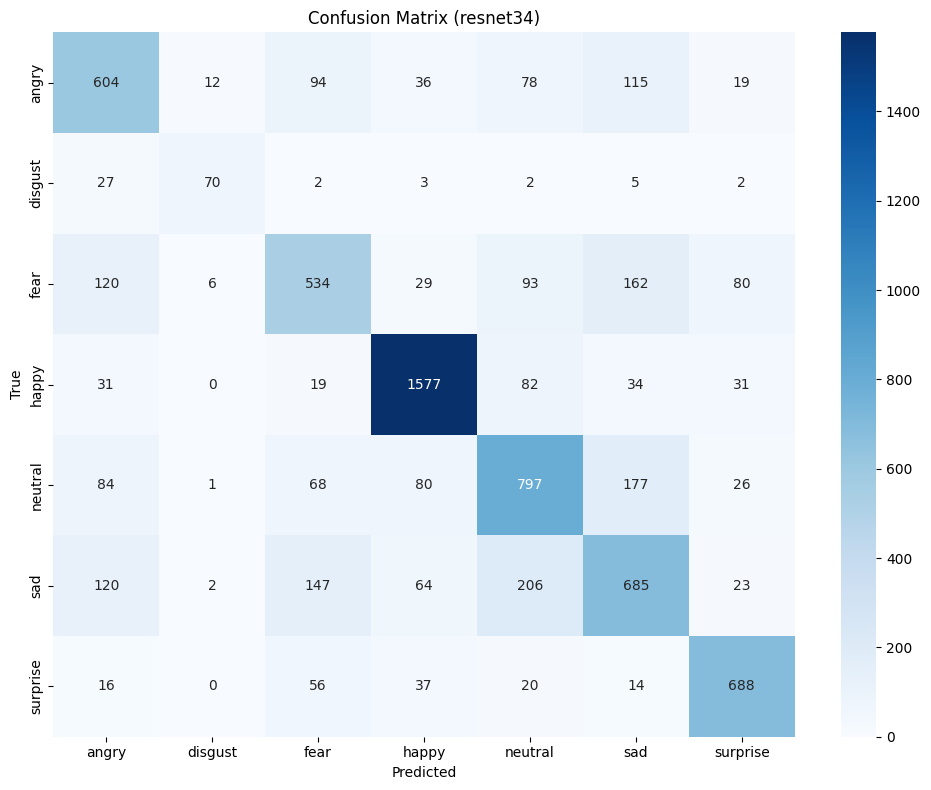

Classification Report:
              precision    recall  f1-score   support

       angry       0.60      0.63      0.62       958
     disgust       0.77      0.63      0.69       111
        fear       0.58      0.52      0.55      1024
       happy       0.86      0.89      0.88      1774
     neutral       0.62      0.65      0.63      1233
         sad       0.57      0.55      0.56      1247
    surprise       0.79      0.83      0.81       831

    accuracy                           0.69      7178
   macro avg       0.69      0.67      0.68      7178
weighted avg       0.69      0.69      0.69      7178



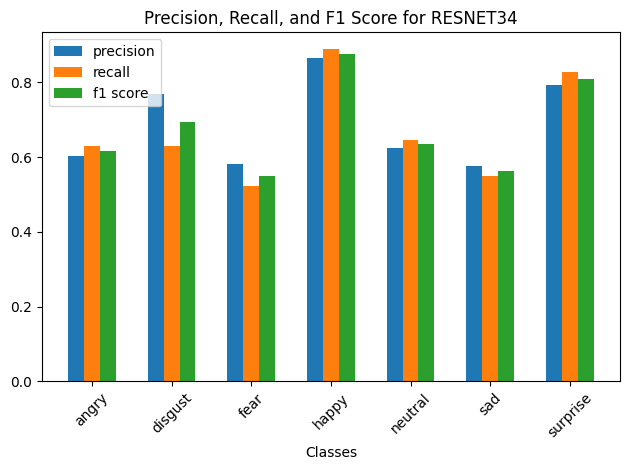

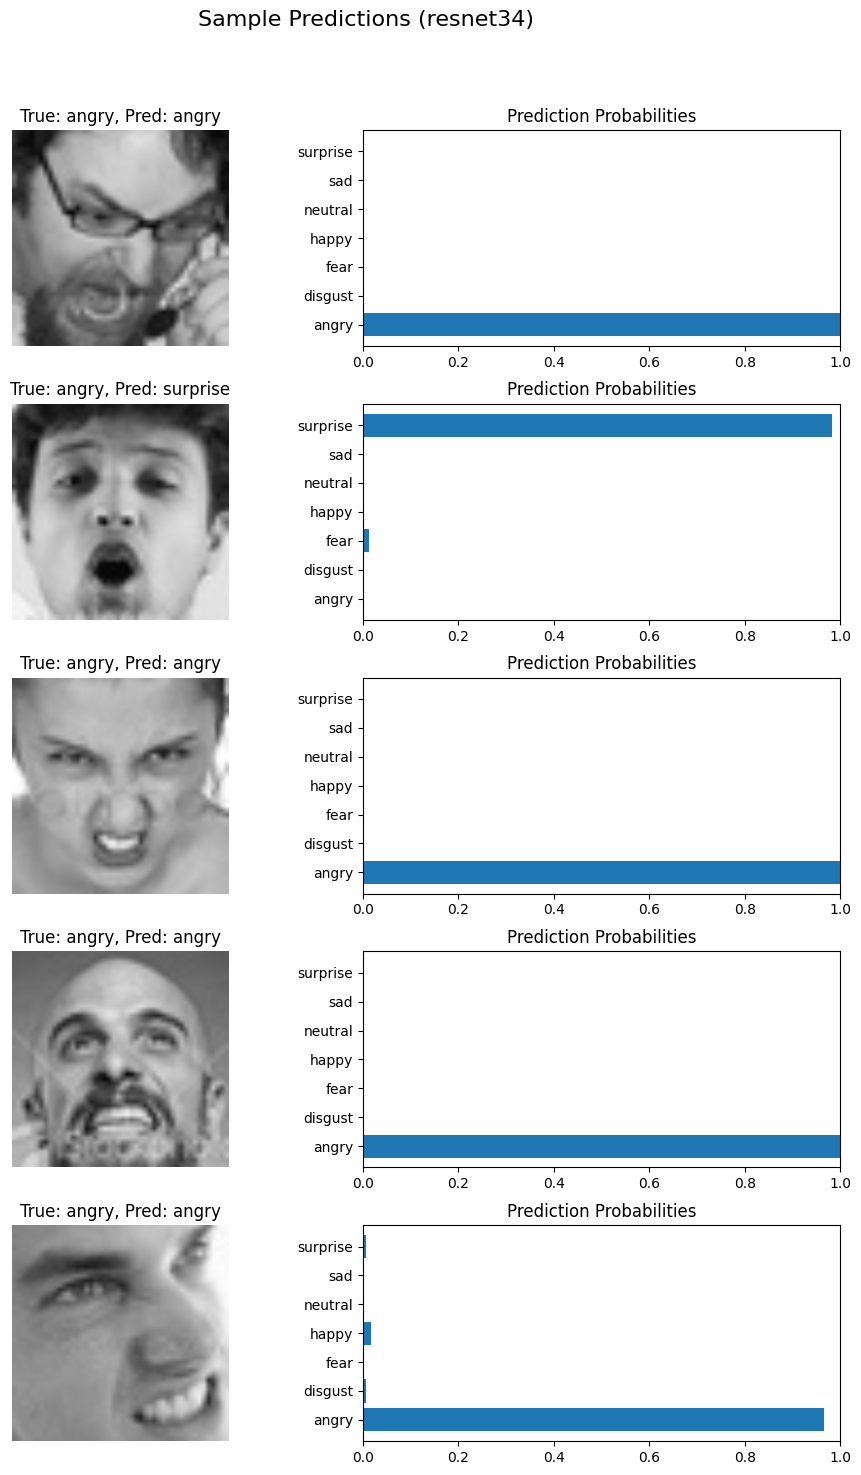


Evaluating CNN model performance...
Using device: cuda
Model loaded successfully from cnn_fer_epoch.pth


/tmp/ipykernel_6598/3882407401.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Test Accuracy: 55.36%


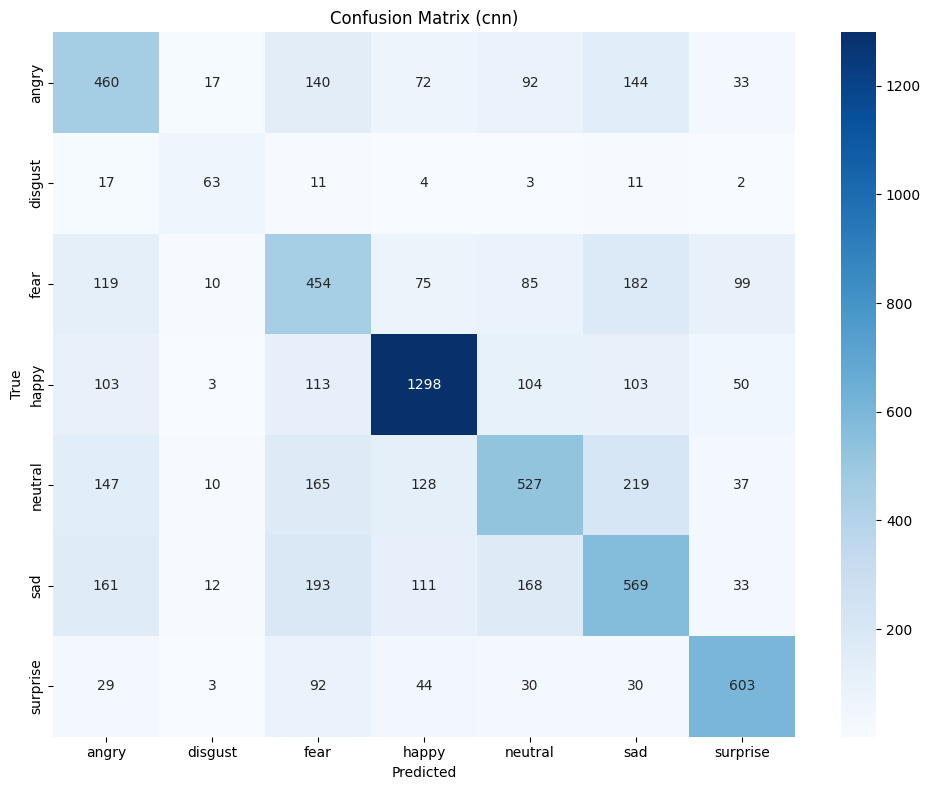

Classification Report:
              precision    recall  f1-score   support

       angry       0.44      0.48      0.46       958
     disgust       0.53      0.57      0.55       111
        fear       0.39      0.44      0.41      1024
       happy       0.75      0.73      0.74      1774
     neutral       0.52      0.43      0.47      1233
         sad       0.45      0.46      0.45      1247
    surprise       0.70      0.73      0.71       831

    accuracy                           0.55      7178
   macro avg       0.54      0.55      0.54      7178
weighted avg       0.56      0.55      0.55      7178



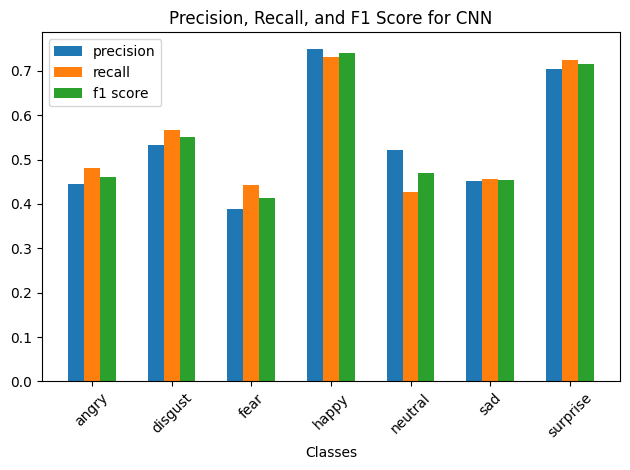

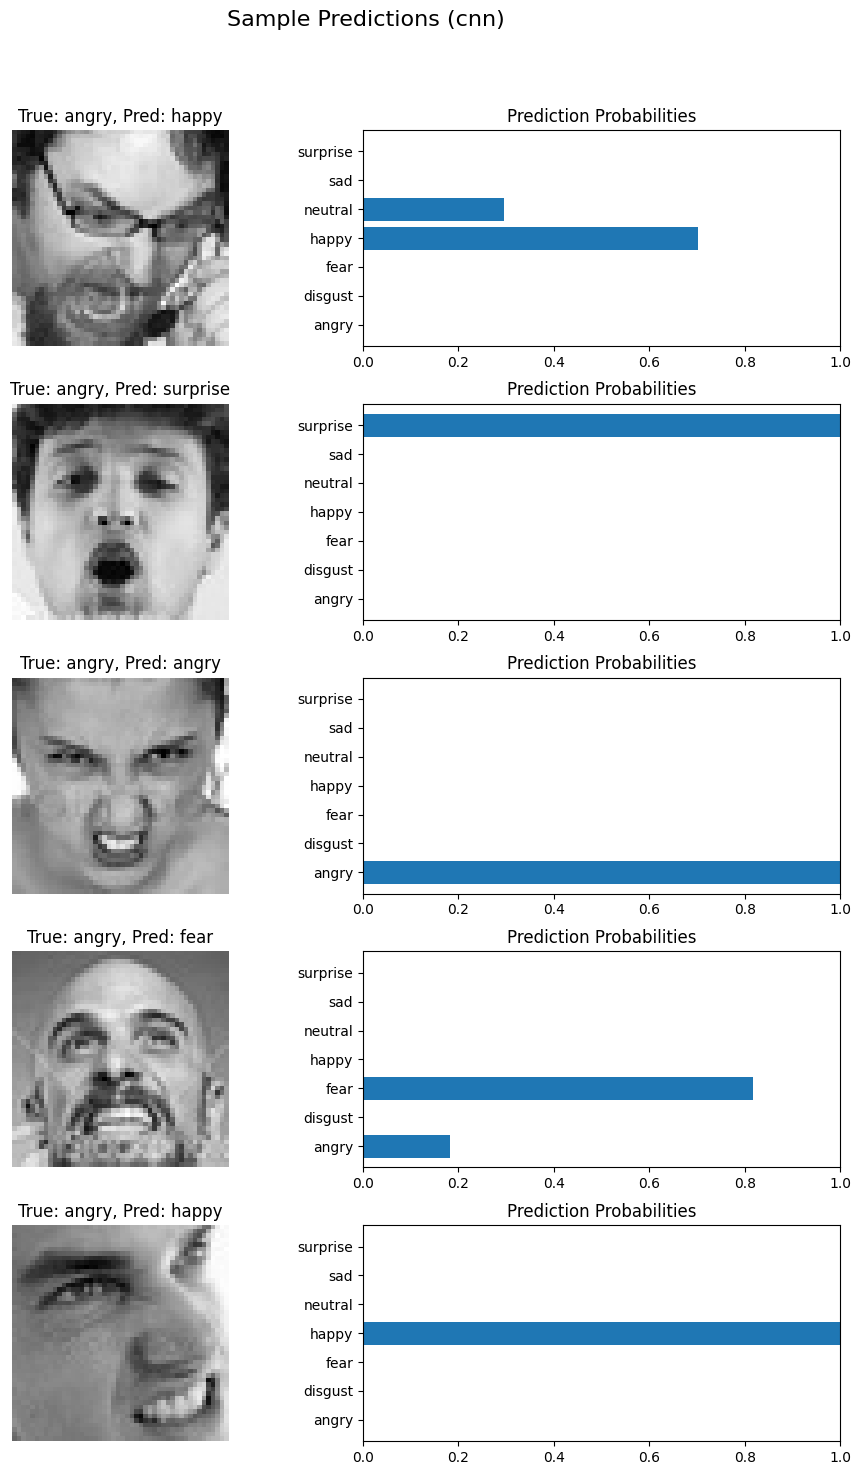


Model Comparison:
ResNet34 Accuracy: 69.03%
CNN Accuracy: 55.36%


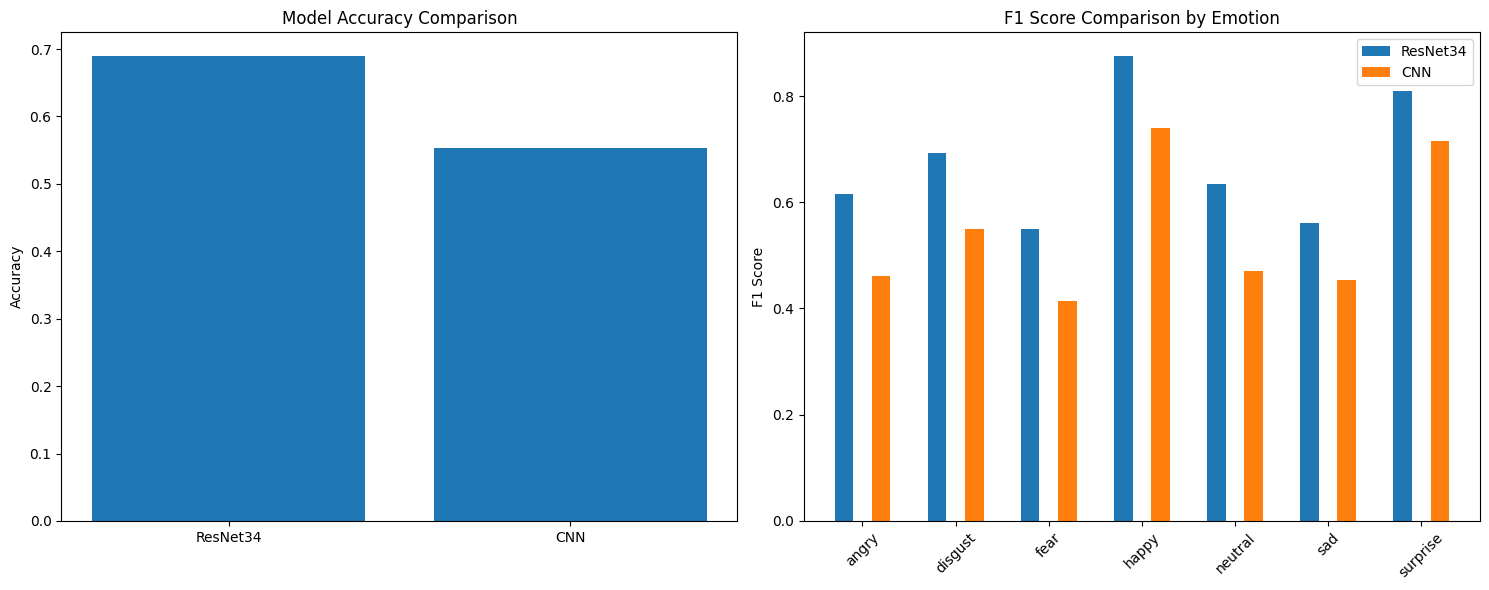

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import torchvision.models as models
from torch.utils.data import DataLoader

def load_model_and_evaluate(model_path, model_type="resnet34"):
    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load the correct model architecture
    if model_type == "resnet34":
        model = models.resnet34(weights=None)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, 7)
    elif model_type == "cnn":
        # CNN model architecture
        class CNN_FacialExpression(nn.Module):
            def __init__(self, num_classes=7):
                super(CNN_FacialExpression, self).__init__()
                
                # Convolutional layers
                self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
                self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
                self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
                
                # Fully connected layers
                self.fc1 = nn.Linear(128*6*6, 512)
                self.fc2 = nn.Linear(512, num_classes)

                # Max Pooling layer
                self.pool = nn.MaxPool2d(2, 2)
            
            def forward(self, x):
                import torch.nn.functional as F
                # Pass through the convolutional layers
                x = self.pool(F.relu(self.conv1(x)))
                x = self.pool(F.relu(self.conv2(x)))
                x = self.pool(F.relu(self.conv3(x)))

                # Flatten the tensor for the fully connected layers
                x = x.view(-1, 128*6*6)
                
                # Fully connected layers
                x = F.relu(self.fc1(x))
                x = self.fc2(x)
                
                return x
        
        model = CNN_FacialExpression(num_classes=7)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Load model weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded successfully from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None, None
    
    model = model.to(device)
    model.eval()
    
    # Prepare data
    import torchvision.transforms as transforms
    from torchvision import datasets
    import os
    
    # Path to the dataset
    dataset_path = os.path.expanduser("~/.cache/kagglehub/datasets/msambare/fer2013/versions/1")
    
    # Image transformations based on model type
    if model_type == "resnet34":
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
    else:  # CNN model
        transform = transforms.Compose([
            transforms.Grayscale(),  # Single channel
            transforms.Resize((48, 48)),
            transforms.ToTensor(),
        ])
    
    # Load test dataset
    test_dataset = datasets.ImageFolder(os.path.join(dataset_path, "test"), transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Evaluate the model
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    
    # Get emotion labels
    emotion_labels = test_dataset.classes
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=emotion_labels, 
                yticklabels=emotion_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({model_type})')
    plt.tight_layout()
    plt.savefig(f'{model_type}_confusion_matrix.png')
    plt.show()
    
    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=emotion_labels))
    
    # Convert to dictionary for plotting
    precision_dict = {emotion_labels[i]: precision[i] for i in range(len(emotion_labels))}
    recall_dict = {emotion_labels[i]: recall[i] for i in range(len(emotion_labels))}
    f1_dict = {emotion_labels[i]: f1[i] for i in range(len(emotion_labels))}
    
    # Plot metrics using the specified format
    # plt.figure(figsize=(12, 6))
    width = 0.2
    x = np.arange(len(emotion_labels))
    
    plt.bar(x - width, precision_dict.values(), width, label='precision')
    plt.bar(x, recall_dict.values(), width, label='recall')
    plt.bar(x + width, f1_dict.values(), width, label='f1 score')
    
    plt.xlabel("Classes")
    plt.xticks(x, emotion_labels, rotation=45)
    plt.legend()
    plt.title(f'Precision, Recall, and F1 Score for {model_type.upper()}')
    plt.tight_layout()
    plt.savefig(f'{model_type}_latest_one.png')
    plt.show()
    
    # Visualize sample predictions
    def visualize_predictions(num_samples=5):
        fig, axes = plt.subplots(num_samples, 2, figsize=(10, 3*num_samples))
        fig.suptitle(f'Sample Predictions ({model_type})', fontsize=16)
        
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                if i >= num_samples:
                    break
                    
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                # Get sample image
                if model_type == "resnet34":
                    img = images[0].cpu().permute(1, 2, 0).numpy()
                    img = (img * 0.5 + 0.5).clip(0, 1)
                else:  # CNN model
                    img = images[0].cpu().squeeze().numpy()
                
                true_label = emotion_labels[labels[0].item()]
                pred_label = emotion_labels[predicted[0].item()]
                
                # Get softmax probabilities
                probs = torch.nn.functional.softmax(outputs[0], dim=0).cpu().numpy()
                
                # Plot image
                if model_type == "resnet34":
                    axes[i, 0].imshow(img)
                else:
                    axes[i, 0].imshow(img, cmap='gray')
                    
                axes[i, 0].set_title(f'True: {true_label}, Pred: {pred_label}')
                axes[i, 0].axis('off')
                
                # Plot probability distribution
                axes[i, 1].barh(emotion_labels, probs)
                axes[i, 1].set_xlim(0, 1)
                axes[i, 1].set_title('Prediction Probabilities')
                
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.savefig(f'{model_type}_sample_predictions.png')
        plt.show()
    
    visualize_predictions()
    
    return accuracy, precision_dict, recall_dict, f1_dict

# Run evaluation for both models
if __name__ == "__main__":
    print("Evaluating ResNet34 model performance...")
    try:
        resnet_acc, resnet_precision, resnet_recall, resnet_f1 = load_model_and_evaluate(
            "resnet34_fer2013_error68.pth", 
            model_type="resnet34"
        )
    except Exception as e:
        print(f"Error evaluating ResNet34: {e}")
    
    print("\nEvaluating CNN model performance...")
    try:
        cnn_acc, cnn_precision, cnn_recall, cnn_f1 = load_model_and_evaluate(
            "cnn_fer_epoch.pth", 
            model_type="cnn"
        )
    except Exception as e:
        print(f"Error evaluating CNN: {e}")
    
    # Compare models if both evaluations were successful
    if resnet_acc is not None and cnn_acc is not None:
        print("\nModel Comparison:")
        print(f"ResNet34 Accuracy: {resnet_acc*100:.2f}%")
        print(f"CNN Accuracy: {cnn_acc*100:.2f}%")
        
        # You could also create a comparison chart here
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Get emotion labels (from either model)
        emotion_labels = list(resnet_precision.keys())
        
        # Create comparison plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot accuracy comparison
        models = ['ResNet34', 'CNN']
        accuracies = [resnet_acc, cnn_acc]
        axs[0].bar(models, accuracies)
        axs[0].set_ylabel('Accuracy')
        axs[0].set_title('Model Accuracy Comparison')
        
        # Plot F1 score comparison by class
        x = np.arange(len(emotion_labels))
        width = 0.2
        
        axs[1].bar(x - width, list(resnet_f1.values()), width, label='ResNet34')
        axs[1].bar(x + width, list(cnn_f1.values()), width, label='CNN')
        axs[1].set_ylabel('F1 Score')
        axs[1].set_title('F1 Score Comparison by Emotion')
        axs[1].set_xticks(x)
        axs[1].set_xticklabels(emotion_labels, rotation=45)
        axs[1].legend()
        
        plt.tight_layout()
        plt.savefig('model_comparison.png')
        plt.show()